In [ ]:
#imports

import os 
import codecs
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import io
import random
import pickle

%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

import keras
import copy
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import LSTM,Concatenate , GRU
from keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from keras.layers import ELU, PReLU, LeakyReLU
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

import pickle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.9.2


In [ ]:
#CONFIGURATION
train_model_for = 'semantics'
#train_model_for = 'pragmatics'
#train_model_for = 'morphology'
#train_model_for = 'syntax'

max_words = 10000
max_answer_len = 25
np.random.seed(6174)
embedding_vector_length = 100
learning_rate = .001
training_epochs = 10

from google.colab import files
uploaded = files.upload()

Saving finalnative.csv to finalnative (1).csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['finalnative.csv'])).astype("str")

df.columns = ["question","answer", "morphology","syntax","semantics","pragmatics"]

from sklearn.utils import shuffle
df = shuffle(df)
df.reset_index(inplace=True, drop=True)

#convert columns
df['morphology'] = df['morphology'].astype(float)
df['syntax'] = df['syntax'].astype(float)
df['semantics'] = df['semantics'].astype(float)
df['pragmatics'] = df['pragmatics'].astype(float)


answers = df["answer"]
questions = df["question"]

#train model for specific score based on config variable
problems = df[train_model_for]


morph_problems = df["morphology"]
syntax_problems = df["syntax"]
sem_problems = df["semantics"]
prag_problems = df["pragmatics"]

#print number of question answer pairs
print("Pairs " + str(len(df['answer'])))

Pairs 11925


In [ ]:
#Answer tokenizer
tokenizer_a = Tokenizer(nb_words=max_words)
tokenizer_a.fit_on_texts(answers)
answer_seqs = tokenizer_a.texts_to_sequences(answers)

#question tokenizer
tokenizer_b = Tokenizer(nb_words=max_words)
tokenizer_b.fit_on_texts(answers)
question_seqs = tokenizer_b.texts_to_sequences(questions)

#find the longest answer
max_found_answer_len = 0
for s in answer_seqs:
    if len(s) > max_found_answer_len:
        max_found_answer_len = len(s)

#find longest question
max_found_question_len = 0
for s in question_seqs:
    if len(s) > max_found_question_len:
        max_found_question_len = len(s)

max_len = max(max_found_answer_len,max_found_question_len)
#pad our sequences according to that length
print(question_seqs[0])
print(len(question_seqs[0]))
answer_data = pad_sequences(answer_seqs,maxlen=max_len,padding="post")
question_data = pad_sequences(question_seqs,maxlen = max_len,padding="post")

print(len(question_data[0]))

print('Shape of answer tensor:', answer_data.shape)
print('Shape of question tensor:', question_data.shape)

#creating labels
print(problems[0])
problems = to_categorical(problems)


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/text.py:234: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


[392, 14, 9, 151, 3, 102, 107]
7
23
Shape of answer tensor: (11925, 23)
Shape of question tensor: (11925, 23)
0.0


In [ ]:
from sklearn.utils import shuffle
train_size = int(0.85 * len(answer_data))

answer_data, question_data, problems = shuffle(answer_data,question_data,problems)

X_train = answer_data[:train_size]
X_test = answer_data[train_size:]

Q_train = question_data[:train_size]
Q_test = question_data[train_size:]

y_train_list = problems[0:train_size]
y_test_list = problems[train_size:]

#print a sample answer
print(answer_data[0])

[479 141   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0]


In [ ]:
#Define Text-Input
text_in = Input(shape=(max_len,), name='answer')
question_in = Input(shape=(max_len,), name='question')

#Embeddings
#Used to convert the encoded data i.e the matrix of indices into a form compatible with LSTM
embedding = Embedding(output_dim=embedding_vector_length, input_dim=max_words, input_length=max_len)(text_in)
embedding_question = Embedding(output_dim=embedding_vector_length, input_dim=max_words, input_length=max_len)(question_in)

#LSTM for Answer
lstm_a1 = LSTM(200, return_sequences = True)(embedding)
lstm_a2 = LSTM(300)(lstm_a1)

#LSTM for Question
lstm_q1= LSTM(200, return_sequences = True)(embedding_question)
lstm_q2 = LSTM(300)(lstm_q1)

#merge layer
merge_layer = keras.layers.concatenate([lstm_a2,lstm_q2])

#Dropout for the hidden_units to be independent from each other
dropout = Dropout(0.22)(merge_layer)

#Hidden Dense Layer
dense_1 = Dense(200)(dropout) 
dropout2 = Dropout(0.22)(dense_1)
elu_layer = ELU()(dropout2)

#Output layers
problemLayer = Dense(2, activation='softmax', name='decision_layer')(elu_layer)

#model
model = Model([text_in,question_in],problemLayer)

#optimizer
adam = Adam(lr = learning_rate)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 answer (InputLayer)            [(None, 23)]         0           []                               
                                                                                                  
 question (InputLayer)          [(None, 23)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 23, 100)      1000000     ['answer[0][0]']                 
                                                                                                  
 embedding_3 (Embedding)        (None, 23, 100)      1000000     ['question[0][0]']               
                                                                                            

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.compile(optimizer = "adam", loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_history = model.fit([X_train,Q_train], y_train_list, epochs = training_epochs, batch_size=64, validation_split=0.2)

Epoch 1/10
127/127 [==============================] - 50s 353ms/step - loss: 0.1064 - accuracy: 0.9774 - val_loss: 0.0889 - val_accuracy: 0.9813
Epoch 2/10
127/127 [==============================] - 41s 326ms/step - loss: 0.0706 - accuracy: 0.9817 - val_loss: 0.0892 - val_accuracy: 0.9813
Epoch 3/10
127/127 [==============================] - 41s 325ms/step - loss: 0.0528 - accuracy: 0.9827 - val_loss: 0.0898 - val_accuracy: 0.9699
Epoch 4/10
127/127 [==============================] - 42s 334ms/step - loss: 0.0419 - accuracy: 0.9832 - val_loss: 0.0905 - val_accuracy: 0.9793
Epoch 5/10
127/127 [==============================] - 42s 327ms/step - loss: 0.0401 - accuracy: 0.9850 - val_loss: 0.0964 - val_accuracy: 0.9813
Epoch 6/10
127/127 [==============================] - 42s 327ms/step - loss: 0.0358 - accuracy: 0.9874 - val_loss: 0.0903 - val_accuracy: 0.9734
Epoch 7/10
127/127 [==============================] - 42s 327ms/step - loss: 0.0369 - accuracy: 0.9884 - val_loss: 0.1018 - val_ac

In [ ]:
#Save the model
model.save('./model_' + train_model_for + '.h5')

#save the answer tokenizer
with open('tokenizer_a.pickle', 'wb') as handle:
    pickle.dump(tokenizer_a, handle, protocol=pickle.HIGHEST_PROTOCOL)

#save the question tokenizer
with open('tokenizer_q.pickle', 'wb') as handle:
    pickle.dump(tokenizer_b, handle, protocol=pickle.HIGHEST_PROTOCOL)


#Note, if dataset is altered, tokenizers must be downloaded and placed in the proper directory

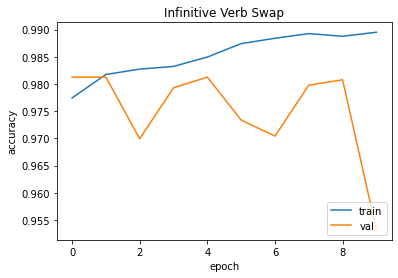

In [ ]:
import matplotlib.pyplot as plt

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Infinitive Verb Swap')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [ ]:
scores = model.evaluate([X_test,Q_test], y_test_list, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 98.32%


In [ ]:
#quick prediction example
p = model.predict([np.array([X_test[0]]),np.array([Q_test[0]])])
pc = np.argmax(p,axis=1)
print(X_test[:1])
print(p)
print(pc)

1/1 [==============================] - 0s 21ms/step
[[1530    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]]
[[9.9985063e-01 1.4931425e-04]]
[0]
